In [ ]:
# !pip install python-graphblas[default]
# !pip install ssgetpy

In [2]:
import numpy as np
import graphblas as gb
gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread

from scipy.sparse import coo_matrix
import timeit
import matplotlib.pyplot as plt

## 0. Вспомогательные функции

#### Преобразование квадратной матрицы смежности в sparse matrix и обратно

In [3]:
def dense2sparse(A):
    rows, cols, vals = A.to_coo()
    mask = vals.nonzero()
    A_sparse = gb.Matrix.from_coo(rows[mask], cols[mask], vals[mask], nrows = A.shape[0], ncols = A.shape[1])
    return A_sparse


def sparse2dense(A_sparse):
    rows, cols, vals = A_sparse.to_coo()
    A = coo_matrix((vals, (rows, cols))).toarray()
    A = gb.Matrix.from_dense(A)
    return A

#### Проверка основных условий для графа

In [4]:
def check_graph(A):
    A = sparse2dense(A).to_dense()
    assert not np.diag(A).sum(), "Есть самозацикленные вершины в графе, требуются нули на главной диагонали матрицы смежности"
    assert A.max() <= 1, "Вес ребер больше единицы, требуется единичный вес ребер"
    assert np.all(A.T == A), "Подан ориентированный граф, требуется неориентированный"
    print("Tests passed")

#### Функция подсчета числа треугольников в графе полным перебором

In [5]:
def brute_force_counting(A):
    triang_sum = 0
    A = A.to_dense()
    num_vert = A.shape[0]
    for i in range(num_vert):
        for j in range(i + 1, num_vert):
            if not A[i][j]:
                continue
            for k in range(j + 1, num_vert):
                if A[j][k] and A[k][i]:
                    triang_sum += 1
    return triang_sum

## 1. Используя python-graphblas реализовать наивный алгоритм, для матрицы смежности вычисляющий и возвращающий количество треугольников неориентированного графа.

In [6]:
def NaiveA3(A):
    A_3 = A.mxm(A.mxm(A))
    return (A_3.diag().reduce(gb.agg.sum).value or 0)//6

## 2. Используя python-graphblas реализовать наивный алгоритм с маской, для матрицы смежности вычисляющий и возвращающий количество треугольников неориентированного графа.

In [7]:
def NaiveMaskA2(A):
    A_2 = A.mxm(A)
    buff = A_2.dup(mask=A.dup(dtype=dtypes.BOOL))
    return (buff.reduce_scalar(gb.monoid.plus).value or 0)//6

## 3. Используя python-graphblas реализовать Сohen's algorithm, вычисляющий количество треугольников неориентированного графа.

In [8]:
def Cohens(A):
    A_tril, A_triu = gb.select.tril(A), gb.select.triu(A)
    buff = A_tril.mxm(A_triu).dup(mask=A.dup(dtype=dtypes.BOOL))
    return (buff.reduce_scalar(gb.monoid.plus).value or 0)//2

## 4. Используя python-graphblas реализовать Sandia algorithm, вычисляющий количество треугольников неориентированного графа.

In [9]:
def Sandia(A):
  A_tril = gb.select.tril(A)
  buff = A_tril.mxm(A_tril).dup(mask=A_tril.dup(dtype=dtypes.BOOL))
  return buff.reduce_scalar(gb.monoid.plus).value or 0

## 5. Используя python-graphblas реализовать функцию, вычисляющую для каждой вершины неориентированного графа количество треугольников, в которых она участвует.

#### Аналогично NaiveA3 вычисляем диагональ А3, и делим на 2 вместо C_{3}^{2} = 6, тк можно двумя путями в неориентрованном графе обойти треугольник и вернуться в ту же вершину

In [10]:
def vert_triang_num(A):
    A_3 = A.mxm(A.mxm(A))
    return list((A_3.diag() // 2).to_dense())

## 6. Тестирование

In [11]:
def test_triag_counting(A_test):
    A1 = NaiveA3(A_test)
    A2 = NaiveMaskA2(A_test)
    A3 = Cohens(A_test)
    A4 = Sandia(A_test)
    A5 = brute_force_counting(sparse2dense(A_test))
    assert A1 == A2 == A3 == A4 == A5, f"Results are different: {A1} {A2} {A3} {A4} {A5}"
    print("Tests passed")
    return A1

In [12]:
A_np_list = [np.random.choice(a=[0, 1], size=(7, 7), p=[0.5, 0.5]) for _ in range(10)]
A_np_list = [(A != A.T).astype(int) for A in A_np_list]
A_coo_list = [dense2sparse(gb.Matrix.from_dense(A_np)) for A_np in A_np_list]

##### Визуализация и тесты:

0 vert_triang_num: [1, 1, 3, 5, 0, 4, 4]
Tests passed
triag_counting: 6


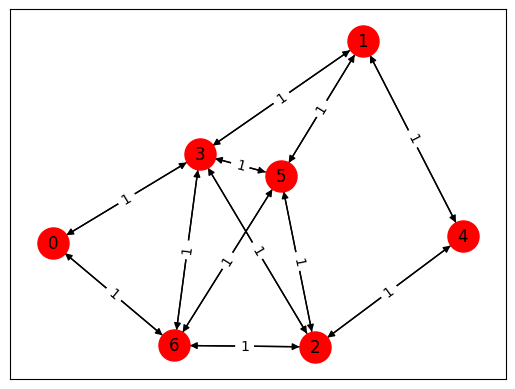

1 vert_triang_num: [0, 0, 1, 0, 1, 0, 1]
Tests passed
triag_counting: 1


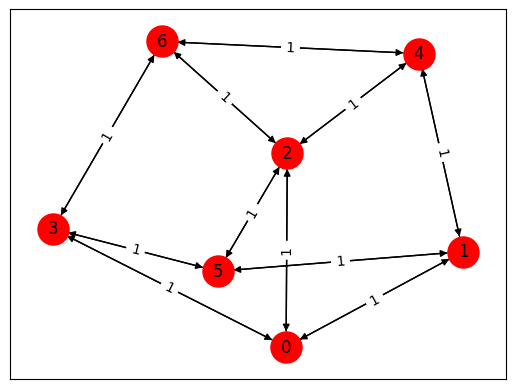

2 vert_triang_num: [3, 3, 3, 3, 3, 3, 3]
Tests passed
triag_counting: 7


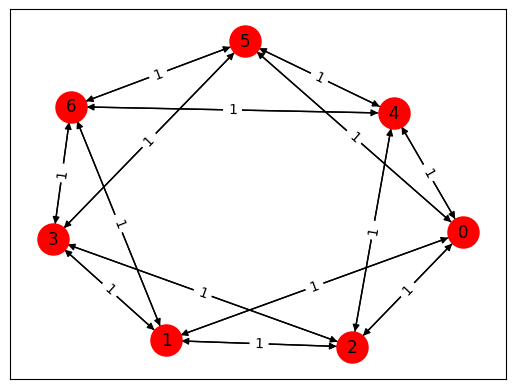

3 vert_triang_num: [1, 3, 3, 1, 0, 3, 1]
Tests passed
triag_counting: 4


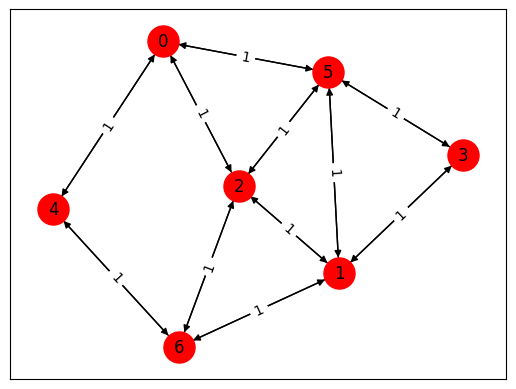

4 vert_triang_num: [2, 0, 2, 0, 1, 1, 0]
Tests passed
triag_counting: 2


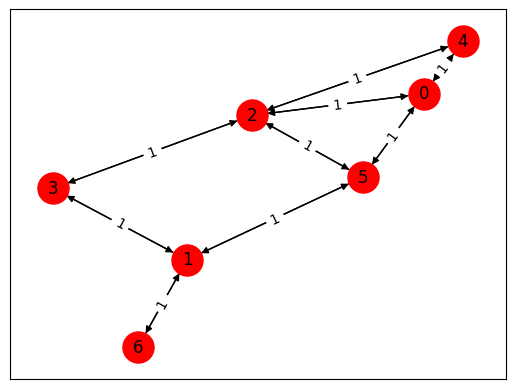

5 vert_triang_num: [2, 0, 1, 2, 0, 1, 0]
Tests passed
triag_counting: 2


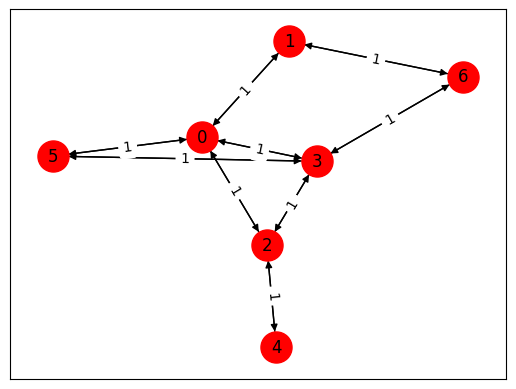

6 vert_triang_num: [2, 3, 7, 5, 4, 6, 9]
Tests passed
triag_counting: 12


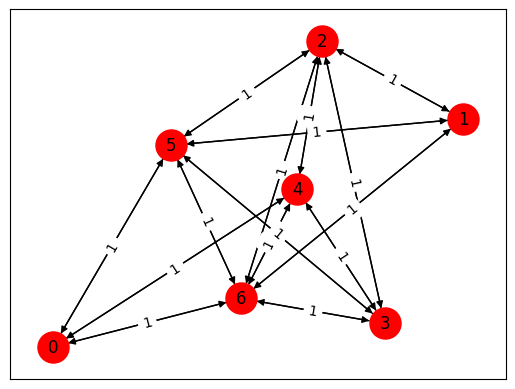

7 vert_triang_num: [0, 3, 3, 3, 1, 1, 4]
Tests passed
triag_counting: 5


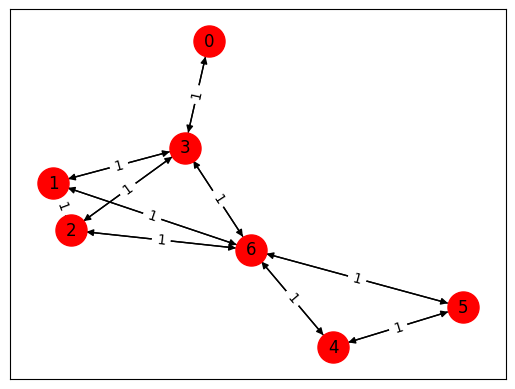

8 vert_triang_num: [0, 4, 4, 0, 3, 1, 3]
Tests passed
triag_counting: 5


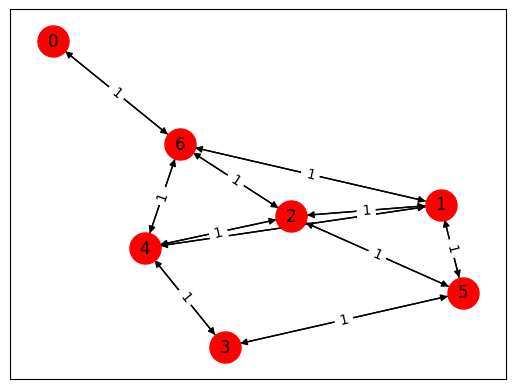

9 vert_triang_num: [0, 0, 0, 0, 0, 0, 0]
Tests passed
triag_counting: 0


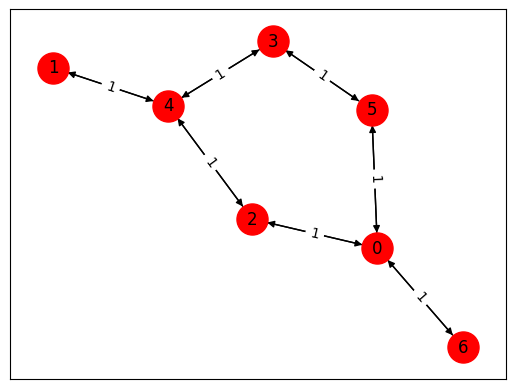

In [13]:
for idx, A_coo in enumerate(A_coo_list):
    print(f"{idx} vert_triang_num: {vert_triang_num(sparse2dense(A_coo))}")
    print(f"triag_counting: {test_triag_counting(A_coo)}")
    gb.viz.draw(A_coo)

## 7. Скачать 10 графов в формате Matrix Market с сайта SuiteSparse Matrix Collection и оценить время работы всех полученных реализаций. Сделать выводы.

In [14]:
import ssgetpy

In [15]:
arr = ssgetpy.search(nzbounds=(10000, None), isspd=True, limit=10)
arr

30,HB,bcsstk08,1074,1074,12960,real,Yes,Yes,1.0,1.0,structural problem,
31,HB,bcsstk09,1083,1083,18437,real,Yes,Yes,1.0,1.0,structural problem,
32,HB,bcsstk10,1086,1086,22070,real,Yes,Yes,1.0,1.0,structural problem,
33,HB,bcsstk11,1473,1473,34241,real,Yes,Yes,1.0,1.0,structural problem,
34,HB,bcsstk12,1473,1473,34241,real,Yes,Yes,1.0,1.0,duplicate structural problem,
35,HB,bcsstk13,2003,2003,83883,real,Yes,Yes,1.0,1.0,computational fluid dynamics problem,
36,HB,bcsstk14,1806,1806,63454,real,Yes,Yes,1.0,1.0,structural problem,
37,HB,bcsstk15,3948,3948,117816,real,Yes,Yes,1.0,1.0,structural problem,
38,HB,bcsstk16,4884,4884,290378,real,Yes,Yes,1.0,1.0,structural problem,
39,HB,bcsstk17,10974,10974,428650,real,Yes,Yes,1.0,1.0,structural problem,


In [16]:
arr.download(extract = True, destpath = "./mtx_files")

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

bcsstk08:   0%|          | 0/42127 [00:00<?, ?B/s]

bcsstk09:   0%|          | 0/38917 [00:00<?, ?B/s]

bcsstk10:   0%|          | 0/63930 [00:00<?, ?B/s]

bcsstk11:   0%|          | 0/98282 [00:00<?, ?B/s]

bcsstk12:   0%|          | 0/98333 [00:00<?, ?B/s]

bcsstk13:   0%|          | 0/316961 [00:00<?, ?B/s]

bcsstk14:   0%|          | 0/282947 [00:00<?, ?B/s]

bcsstk15:   0%|          | 0/357935 [00:00<?, ?B/s]

bcsstk16:   0%|          | 0/844049 [00:00<?, ?B/s]

bcsstk17:   0%|          | 0/1915413 [00:00<?, ?B/s]

In [17]:
import glob
import os
mtx_files = glob.glob("mtx_files/*/*.mtx")
A_list = [mmread(path) for path in mtx_files]

In [18]:
def preprocess_graph(A):
    A = sparse2dense(A)
    A_np = A.to_dense()
    A_np = (A_np != 0).astype(int)
    np.fill_diagonal(A_np, 0)
    A_final = dense2sparse(gb.Matrix.from_dense(A_np))
    return A_final

In [19]:
A_list_pr = [preprocess_graph(A) for A in A_list]

In [20]:
for A in A_list_pr:
    check_graph(A)

Tests passed
Tests passed
Tests passed
Tests passed
Tests passed
Tests passed
Tests passed
Tests passed
Tests passed
Tests passed


In [21]:
def check_time(A_list):
    A_list = sorted(A_list, key=lambda x: x.nvals)
    naive_a3 = []
    naive_mask_a2 = []
    cohens = []
    sandia = []
    for A in A_list:
        naive_a3.append(timeit.timeit(lambda: NaiveA3(A), number=3))
        naive_mask_a2.append(timeit.timeit(lambda: NaiveMaskA2(A), number=3))
        cohens.append(timeit.timeit(lambda: Cohens(A), number=3))
        sandia.append(timeit.timeit(lambda: Sandia(A), number=3))

    plt.figure(figsize=(30, 30))
    plt.plot(naive_a3, label="naive_a3")
    plt.plot(naive_mask_a2, label="naive_mask_a2")
    plt.plot(cohens, label="cohens")
    plt.plot(sandia, label="sandia")
    plt.xlabel('nonzero vals')
    plt.ylabel('time')
    plt.xticks(np.arange(len(A_list)), labels = [str(A.nvals) for A in A_list])
    plt.legend()
    plt.show()

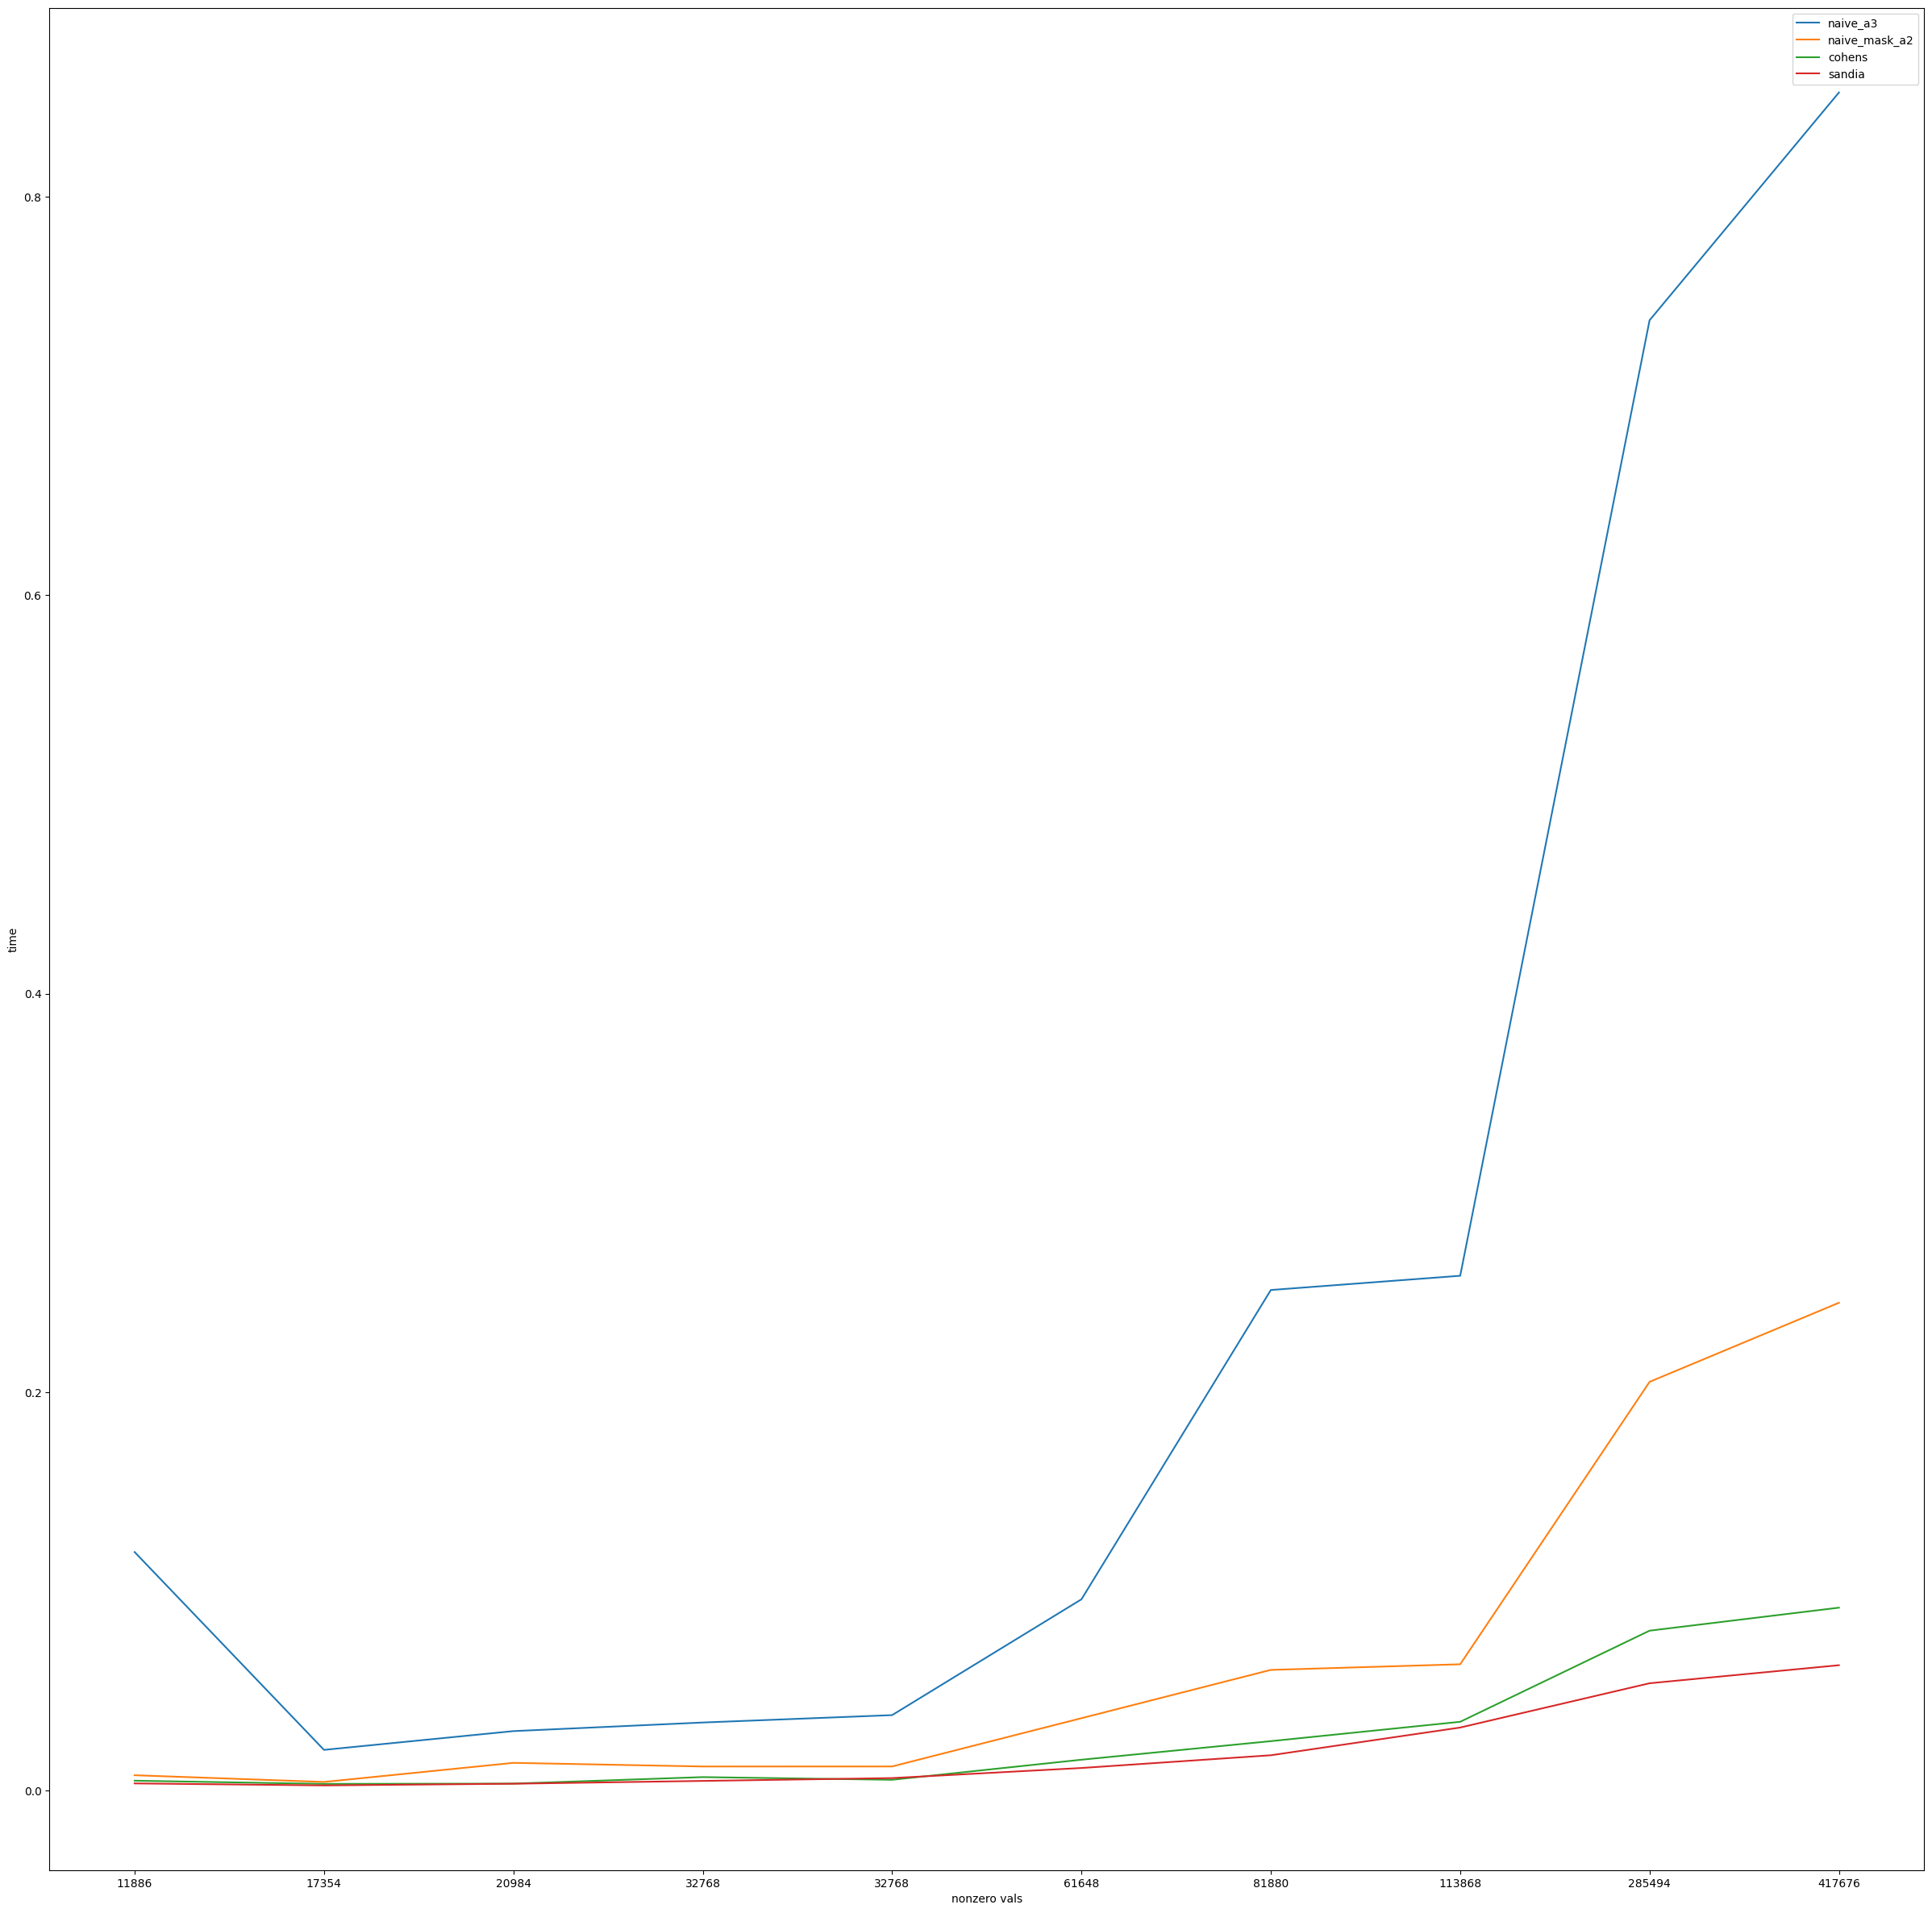

In [22]:
check_time(A_list_pr)

В целом, можно было ожидать, что примерно для наивного А3 алгоритма будет в каком-то роде "кубическая" зависимость от числа ненулевых элементов матрицы, для остальных "квадратичная", но с разными коэфицентами (не строго математически, тк тут разреженная матрица - другие ассимптотики и в целом маскирование тоже занимает ресурсы), лучше всего работает sandia, потом cohens, потом naive_mask_a2, и хуже всего naive_a3

## 8. Реализовать генератор случайных неориентированных графов, в котором можно задавать количество вершин и степень разреженности графа. Путём генерации случайных графов различного размера и с разной степенью разреженности, оценить время работы всех полученных реализаций и исследовать границы их применимости. Сделать выводы.

In [23]:
def random_graph(n, p):
    A_np_tril = np.tril(np.random.choice(a=[0, 1], size=(n, n), p=[1 - p, p]), -1)
    A_np = A_np_tril + A_np_tril.T
    return dense2sparse(gb.Matrix.from_dense(A_np))

In [24]:
n = 10
p = 0.5
A = random_graph(n, p)
check_graph(A)
print(A)

Tests passed
"M_551"    nvals  nrows  ncols  dtype         format
gb.Matrix     52     10     10  INT64  bitmapr (iso)
----------------------------------------------------
   0  1  2  3  4  5  6  7  8  9
0     1           1  1  1  1  1
1  1     1  1  1  1        1   
2     1        1        1  1   
3     1                    1   
4     1  1        1  1  1     1
5  1  1        1        1  1  1
6  1           1        1  1  1
7  1     1     1  1  1        1
8  1  1  1  1     1  1         
9  1           1  1  1  1      


In [25]:
n_list = [10, 100, 1000, 10000, 100000]
p_list = np.linspace(0.2, 0.8, 5)

Фиксированная плотность, меняющееся n

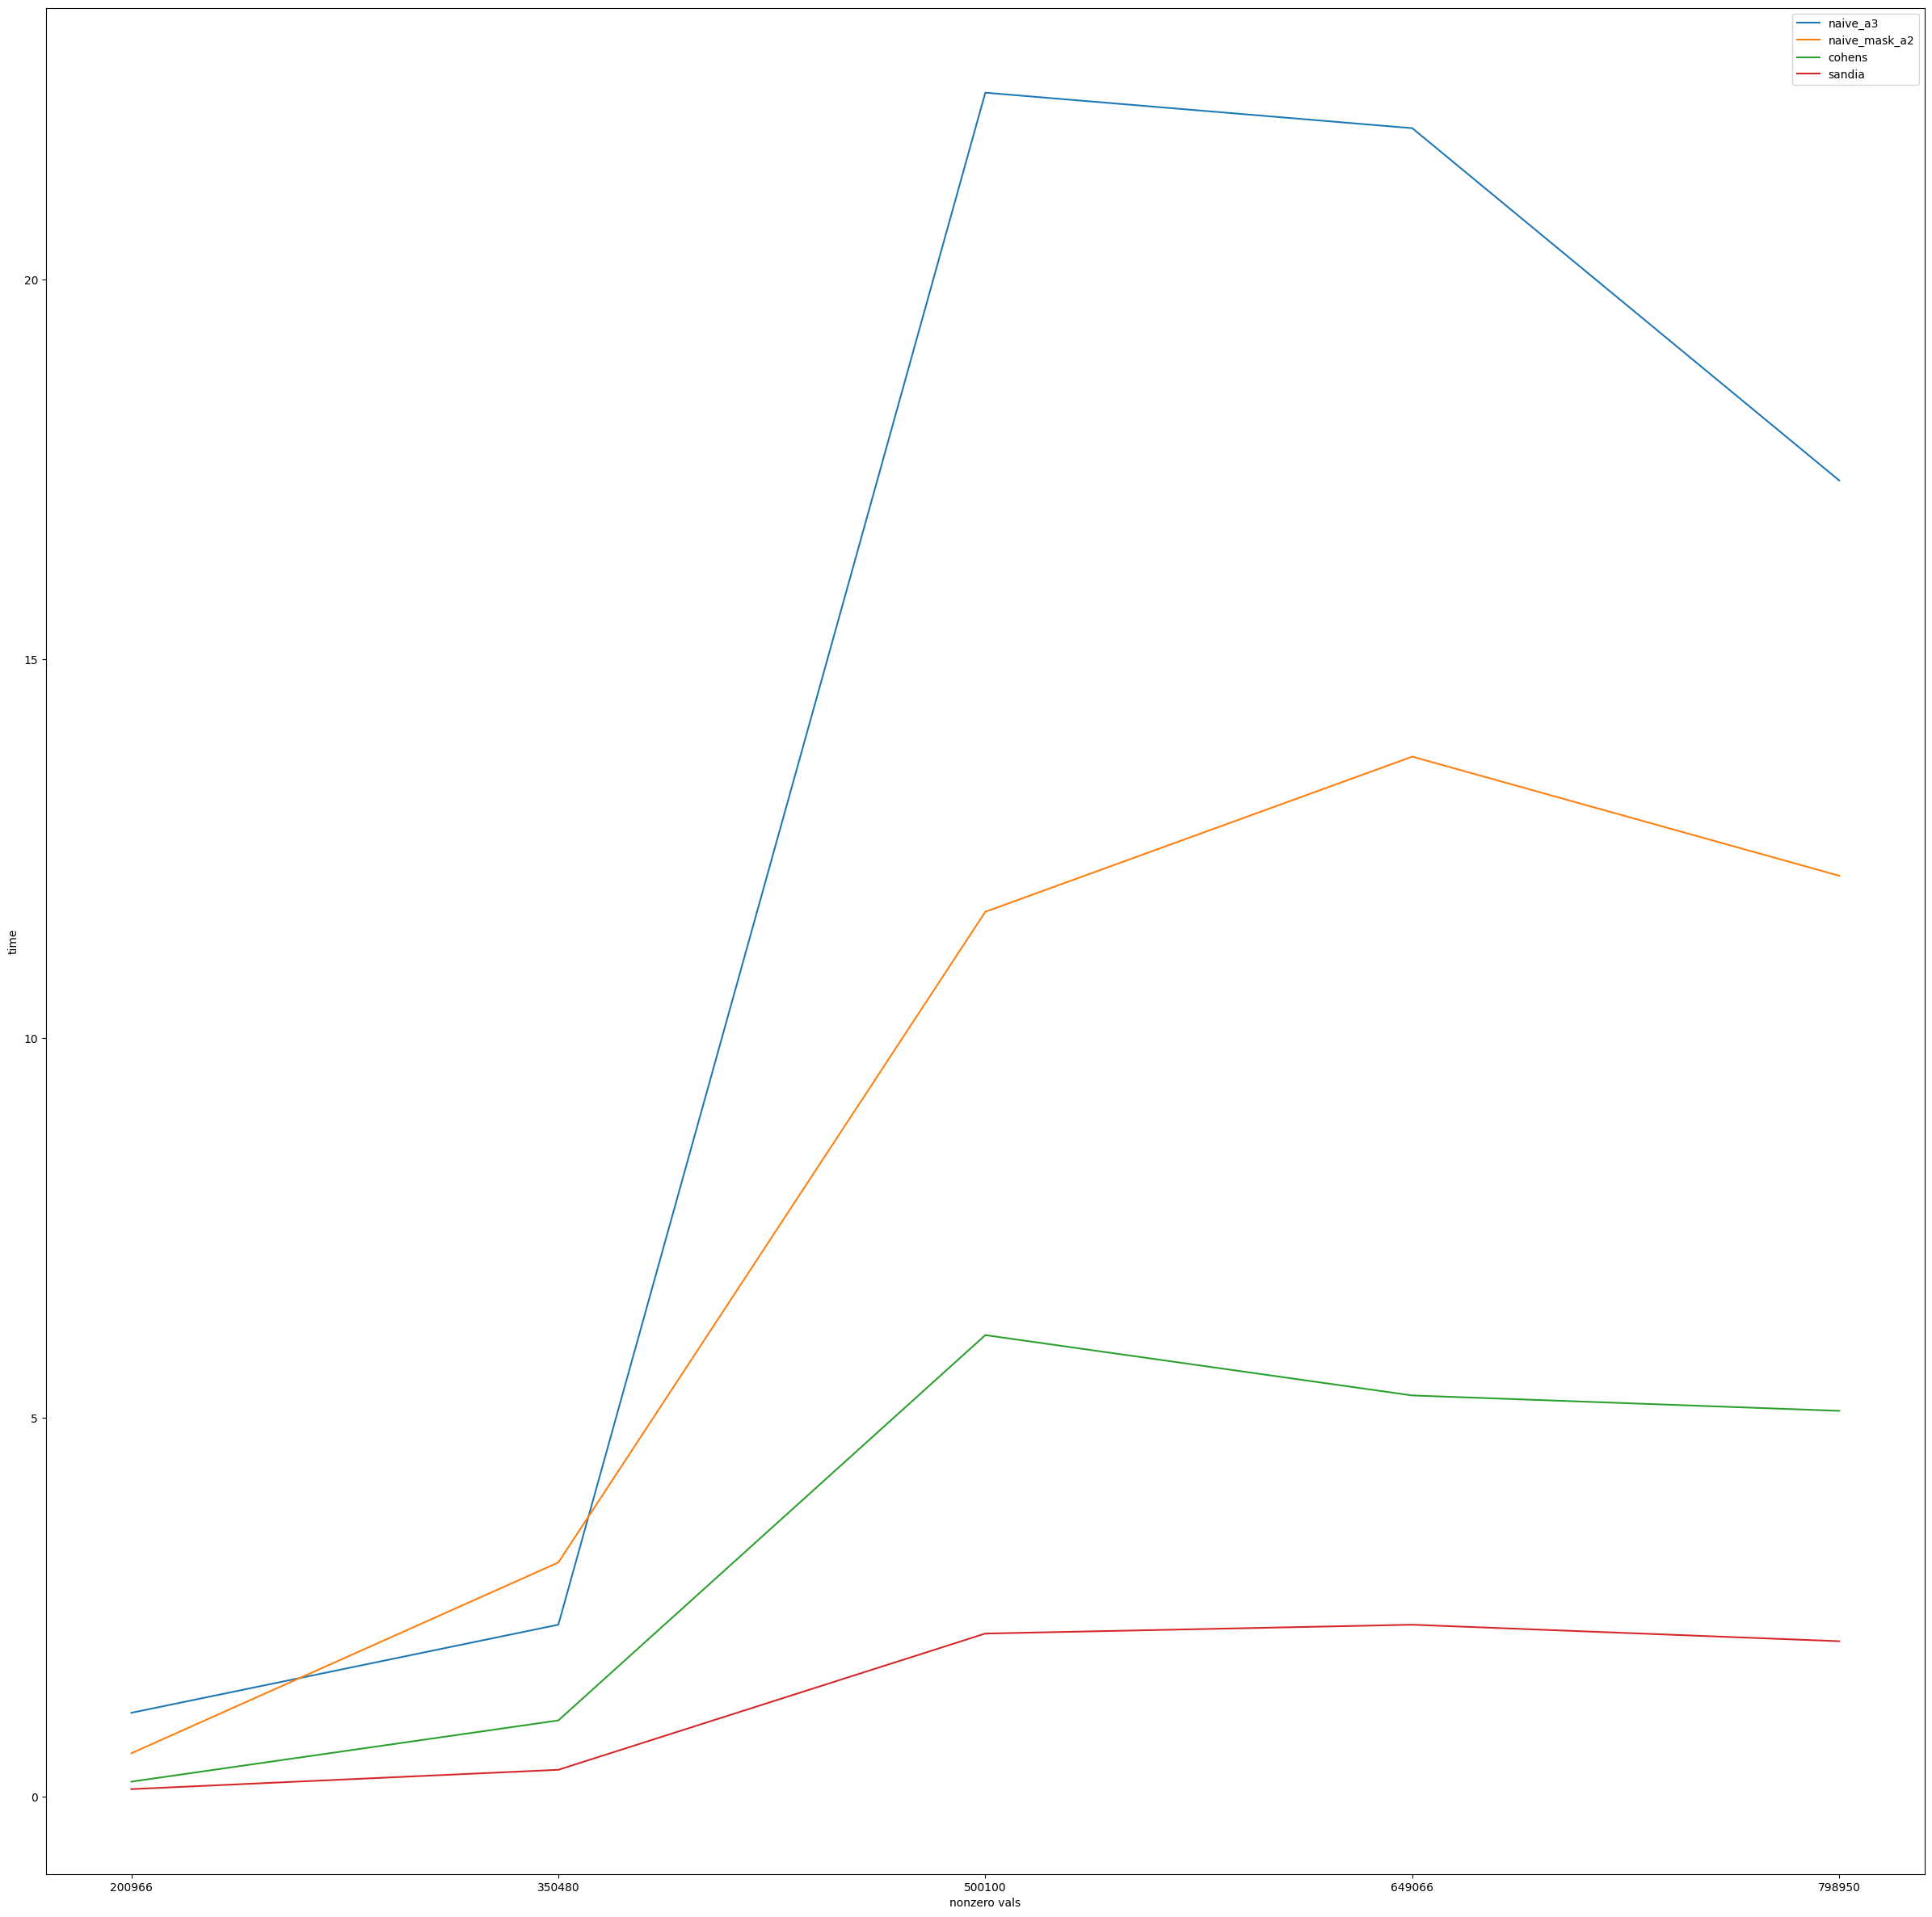

In [26]:
n = n_list[2]
A_list = [random_graph(n, p) for p in p_list]
check_time(A_list)

Фиксированное n, меняющееся p

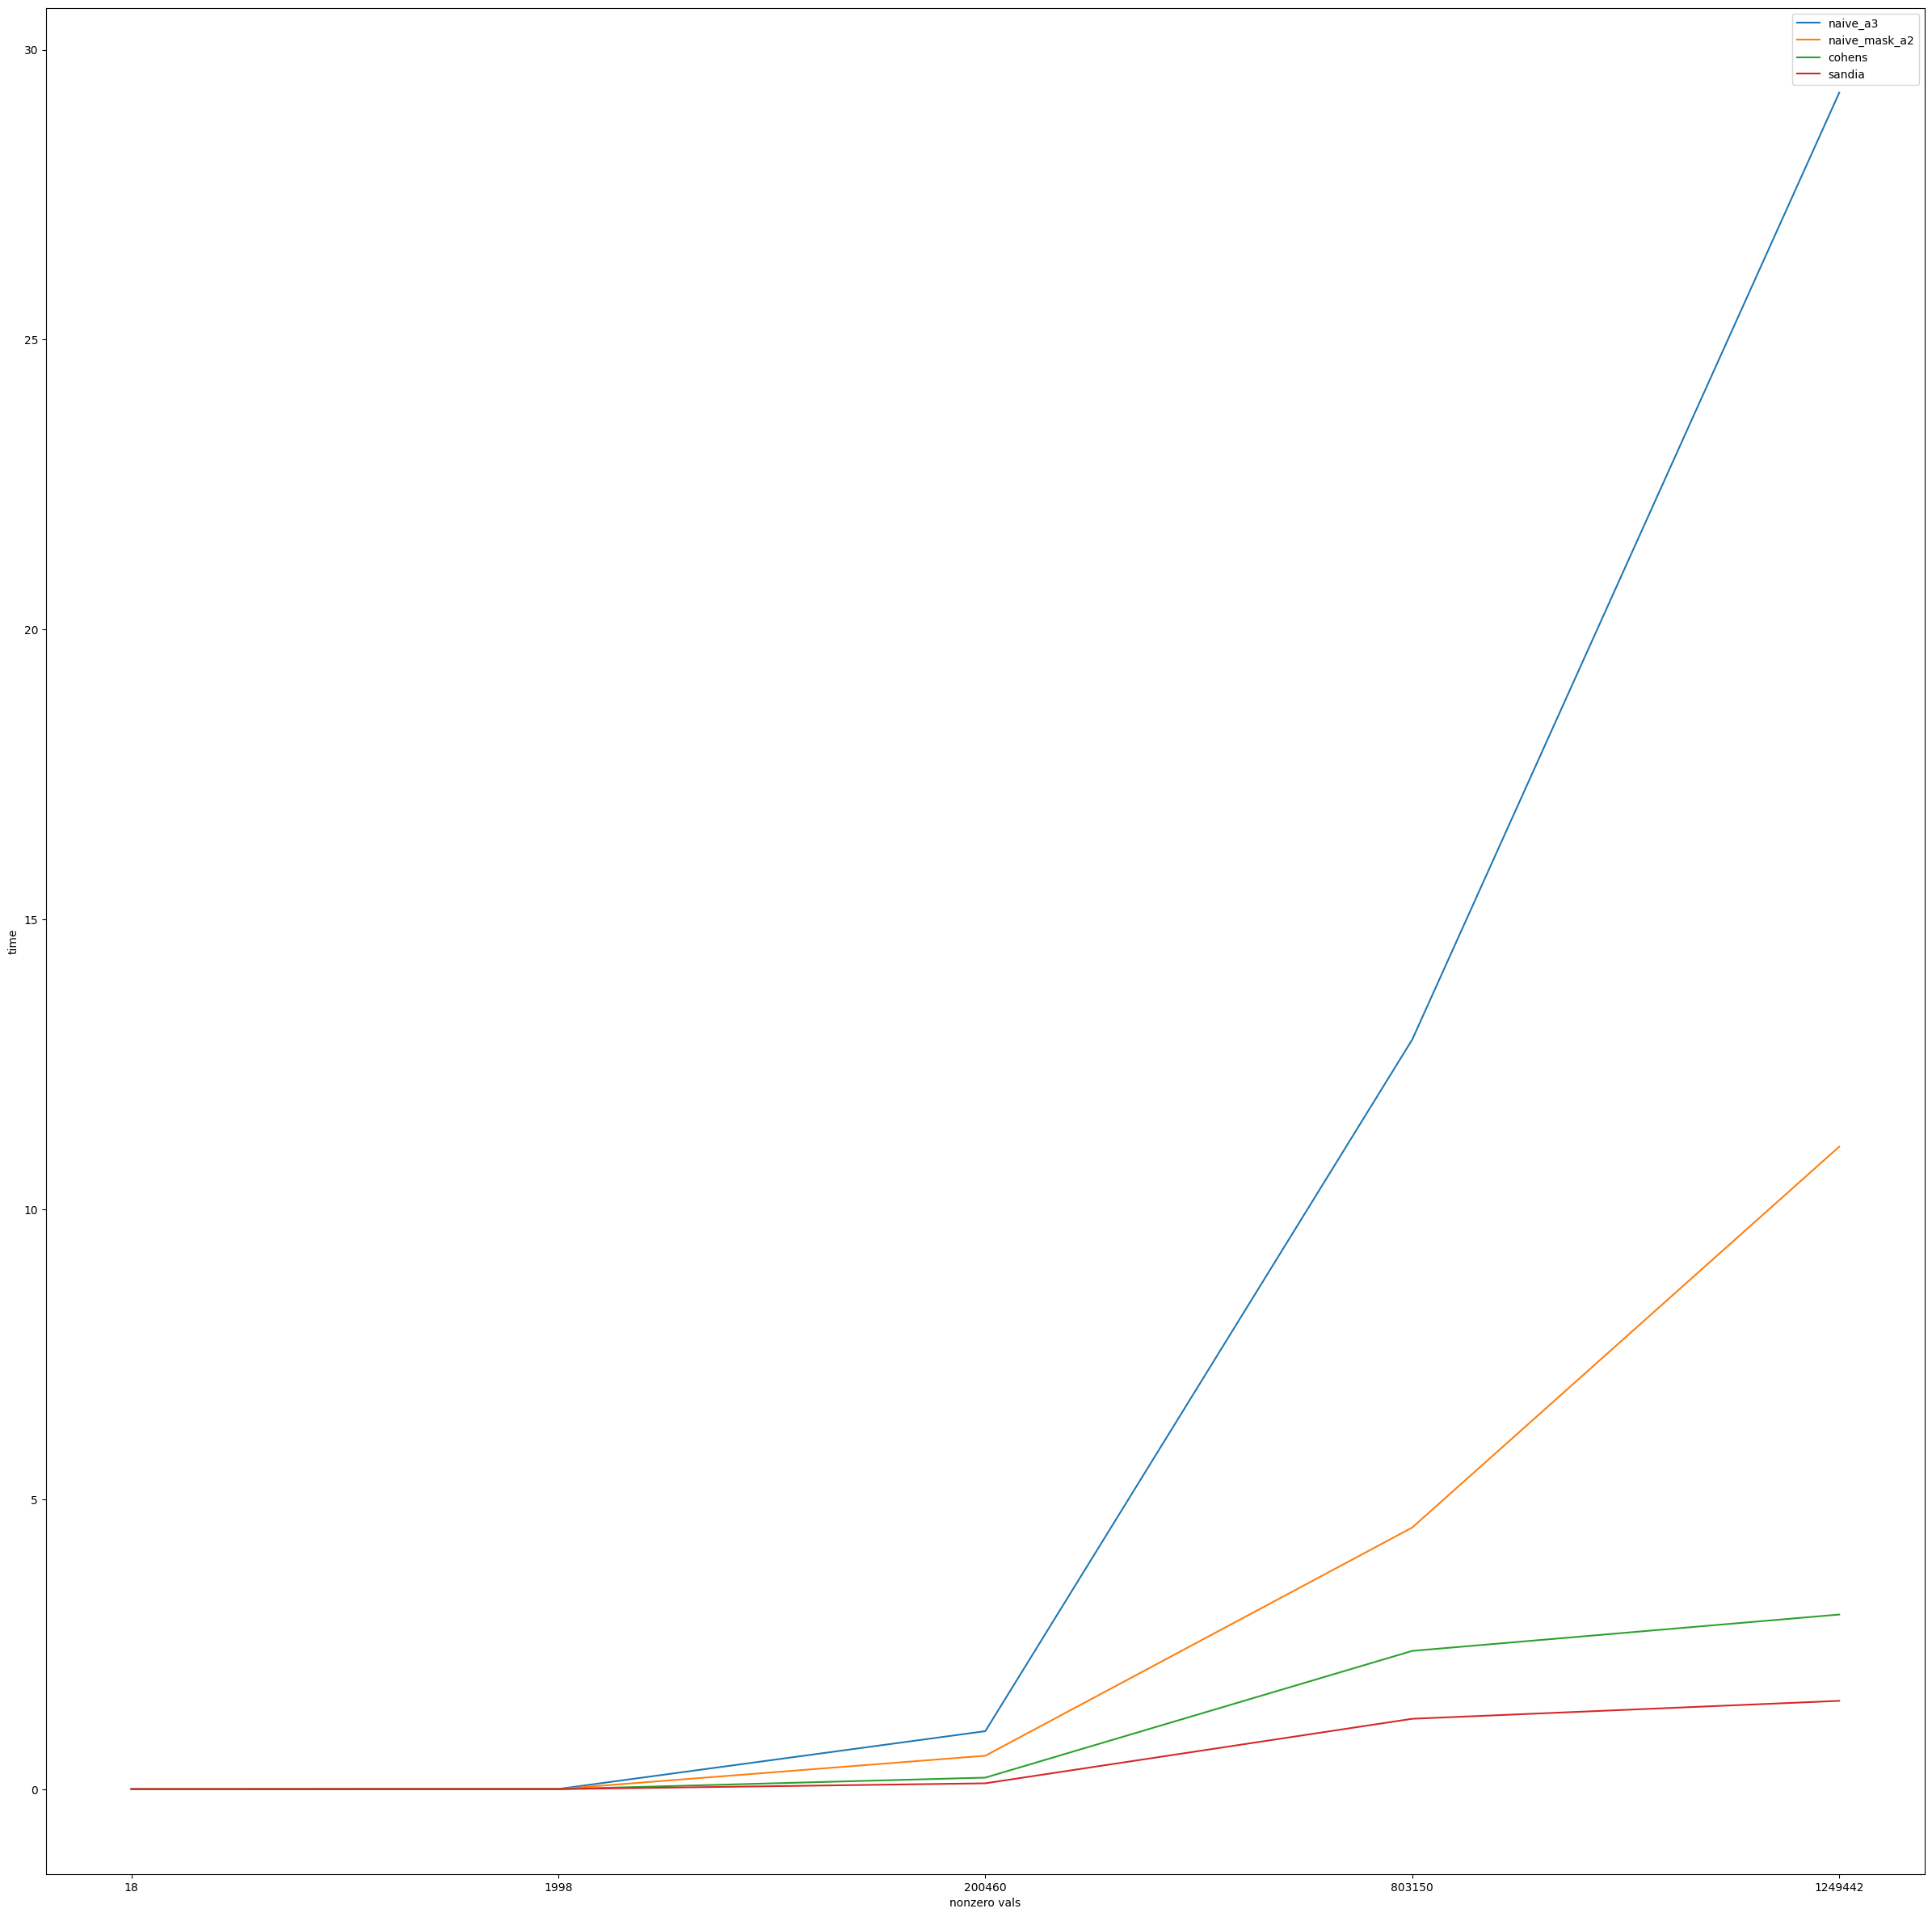

In [27]:
p = p_list[0]
n_list = [10, 100, 1000, 2000, 2500]
A_list = [random_graph(n, p) for n in n_list]
check_time(A_list)

Результаты аналогичны предыдущему тестированию - есть зависимость от числа ненулевых элементов, положение методов аналогично относительно друг друга (лучше всего работает sandia, потом cohens, потом naive_mask_a2, и хуже всего naive_a3)